# Toy: AR1 model

Note, you can find the original version of this notebook at [https://github.com/mackelab/sbi/blob/main/tutorials/02_flexible_interface.ipynb](https://github.com/mackelab/sbi/blob/main/tutorials/02_flexible_interface.ipynb) in the `sbi` repository.

## Main syntax

```Python
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi

simulator, prior = prepare_for_sbi(simulator, prior)
inference = SNPE(prior)

theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=1000)
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)
```

In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from sbi import utils
from sbi import analysis
from sbi import inference
from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi

seed = 0
torch.manual_seed(seed)

/Users/albertca/miniconda3/envs/sbi_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
# import torch
# if torch.backends.mps.is_available():
#     mps_device = torch.device("mps")
#     x = torch.ones(1, device=mps_device)
#     print (x)
# else:
#     print ("MPS device not found.")
# prior = torch.distributions.Uniform(torch.tensor([0.0,0.0], device="mps:0"), torch.tensor([1.0,1.0], device="mps:0"))
# inference = SNPE(prior=prior, device="mps:0", density_estimator=neural_posterior)

tensor([1.], device='mps:0')


In [2]:
num_dim = 2
prior = utils.BoxUniform(low=[4.2,0.005], high=[5.8,0.025])

In [3]:
def generate_ar1_time_series(theta):
    time_series = np.zeros(length)
    time_series[0] = x_0
    for t in range(1, length):
        noise = np.random.normal(0, theta[1])
        time_series[t] =  theta[0] * time_series[t - 1]**2 * (1-time_series[t - 1]) + noise
    return time_series

In [4]:
length = 200
x_0 = 0.25
simulator, prior = prepare_for_sbi(generate_ar1_time_series, prior)

In [5]:
class SummaryNet(nn.Module):
    
    def __init__(self,
                 in_channels = (1, 8, 16),
                 out_channels = (8, 16, 32),
                 kernel_sizes =  (5, 2, 5), 
                 padding = (0,0,0),
                 encoded_space_dim = 3, 
                 drop_p = 0.5,
                 act = nn.LeakyReLU,
                 seq_length = 200,
                 linear = 10,
                ):
        """
        Convolutional Network with three convolutional and two dense layers
        Args:
            in_channels : inputs channels
            out_channels : output channels
            kernel_sizes : kernel sizes
            padding : padding added to edges
            encoded_space_dim : dimension of encoded space
            drop_p : dropout probability
            act : activation function
            seq_len : length of input sequences 
            weight_decay : l2 regularization constant
            linea : linear layer units
        """
        super().__init__()
    
        # Retrieve parameters
        self.in_channels = in_channels #tuple of int, input channels for convolutional layers
        self.out_channels = out_channels #tuple of int, of output channels 
        self.kernel_sizes = kernel_sizes #tuple of tuples of int kernel size, single integer or tuple itself
        self.padding = padding
        self.encoded_space_dim = encoded_space_dim
        self.drop_p = drop_p
        self.act = act
        self.seq_length = seq_length
        self.linear = linear 
        self.pool_division = 4
 
      
        ### Network architecture
        # First convolutional layer (2d convolutional layer
        self.first_conv = nn.Sequential(
            nn.Conv1d(self.in_channels[0], self.out_channels[0], self.kernel_sizes[0], padding=self.padding[0]), 
            #nn.BatchNorm1d(self.out_channels[0]),
            self.act(inplace = True),
            nn.Dropout(self.drop_p, inplace = False),
            nn.AvgPool1d(self.pool_division)
        )
        
        # Second convolution layer
        self.second_conv = nn.Sequential(
            nn.Conv1d(self.in_channels[1], self.out_channels[1], self.kernel_sizes[1], padding=self.padding[1]), 
            #nn.BatchNorm1d(self.out_channels[1]),
            self.act(inplace = True),
            nn.Dropout(self.drop_p, inplace = False),
            nn.AvgPool1d(self.pool_division)
        )
        
        # Third convolutional layer
        self.third_conv = nn.Sequential(
            nn.Conv1d(self.in_channels[2], self.out_channels[2], self.kernel_sizes[2], padding=self.padding[2]), 
            #nn.BatchNorm1d(self.out_channels[2]),
            self.act(inplace = True),
            nn.Dropout(self.drop_p, inplace = False),
            nn.AvgPool1d(self.pool_division)
        )


        # Flatten layer
        self.flatten = nn.Flatten(start_dim=-2)
        
        # Liner dimension after 2 convolutional layers
        self.lin_dim = int((((self.seq_length-self.kernel_sizes[0]+1)/self.pool_division+1-self.kernel_sizes[1])/self.pool_division+1-self.kernel_sizes[2])/self.pool_division)
        
        # linear encoder
        self.encoder_lin= nn.Sequential(
                # First linear layer
                nn.Linear(self.out_channels[2]*self.lin_dim, self.linear),
                #nn.BatchNorm1d(self.linear),
                self.act(inplace = True),
                nn.Dropout(self.drop_p, inplace = False),
                # Second linear layer
                nn.Linear(self.linear, self.encoded_space_dim)
            )
        # # normalizing latent space layer
        #self.normalize_enc = nn.BatchNorm1d(self.encoded_space_dim)



    def forward(self, x):
        x =x.view(-1,1,200)
        x = self.first_conv(x)
        x = self.second_conv(x)
        x = self.third_conv(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x.view(-1,3)
        #return x.squeeze()
    
embedding_net = SummaryNet()


In [6]:
# input_size = 200
# num_classes = 3

# class SummaryNet(nn.Module):
#     def __init__(self):
#         super().__init__()
#         # 1D convolutional layer
#         self.conv1 = nn.Conv1d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
#         # Maxpool layer
#         self.pool = nn.MaxPool1d(kernel_size=10, stride = 10)
#         # Fully connected layer
#         self.fc = nn.Linear(in_features=6 * (input_size // 10), out_features=num_classes)

#     def forward(self, x):
#         # Assuming x is of shape (batch_size, 1, input_size)
#         x =x.view(-1,1,200)
#         x = self.conv1(x)
#         x = self.pool(x)
#         # Flatten the output before passing it to the fully connected layer
#         x = x.view(-1,6*20)
#         x = self.fc(x)
#         return x

# embedding_net = SummaryNet()


In [7]:
# instantiate the neural density estimator
neural_posterior = utils.posterior_nn(
    model="maf", embedding_net=embedding_net, hidden_features=10, num_transforms=2
)

# setup the inference procedure with the SNPE-C procedure
inference = SNPE(prior=prior, density_estimator=neural_posterior)

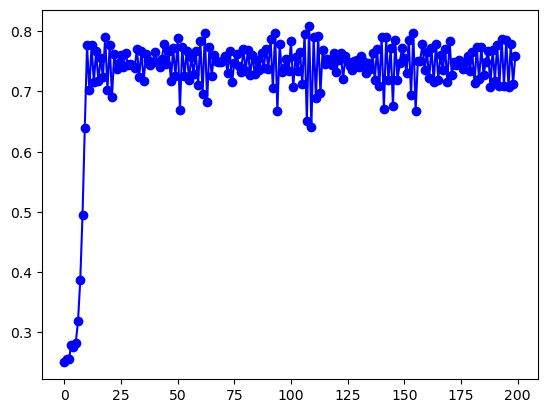

In [9]:
# Example usage:
c = 5.3
noise_std = 0.015  # Standard deviation of the additive noise

x_o = generate_ar1_time_series([c, noise_std])
plt.plot(x_o, label='Time Series Data', color='blue', marker='o', linestyle='-')

In [10]:
num_rounds = 7
# The specific observation we want to focus the inference on.

posteriors = []
proposal = prior

for _ in range(num_rounds):
    theta, x = simulate_for_sbi(simulator, proposal, num_simulations=1000)

    # In `SNLE` and `SNRE`, you should not pass the `proposal` to `.append_simulations()`
    density_estimator = inference.append_simulations(
        theta, x, proposal=proposal
    ).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:02<00:00, 436.44it/s]


 Neural network successfully converged after 108 epochs.

Drawing 1000 posterior samples: 1080it [00:00, 137372.20it/s]           
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:02<00:00, 439.78it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 146 epochs.

Drawing 1000 posterior samples: 1065it [00:00, 12675.86it/s]            
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:02<00:00, 440.55it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 36 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]WARNING:root:Only 0.993% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    593 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
Drawing 1000 posterior samples: 1031it [00:00, 10315.57it/s]            
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:02<00:00, 440.35it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 49 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]WARNING:root:Only 0.827% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    909 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
Drawing 1000 posterior samples: 1003it [00:00, 9430.83it/s]                         
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:02<00:00, 440.70it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 29 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]WARNING:root:Only 0.718% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    921 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
Drawing 1000 posterior samples: 1030it [00:00, 10946.72it/s]            
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:02<00:00, 444.02it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 41 epochs.

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]WARNING:root:Only 0.782% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    914 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
Drawing 1000 posterior samples: 1015it [00:00, 7716.10it/s]                         
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:02<00:00, 440.27it/s]


Using SNPE-C with atomic loss
 Neural network successfully converged after 50 epochs.

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]WARNING:root:Only 0.680% proposal samples are
                    accepted. It may take a long time to collect the remaining
                    9932 samples. Consider interrupting (Ctrl-C) and switching to
                    `build_posterior(..., sample_with='mcmc')`.
Drawing 10000 posterior samples: 10009it [00:01, 7564.86it/s]                          


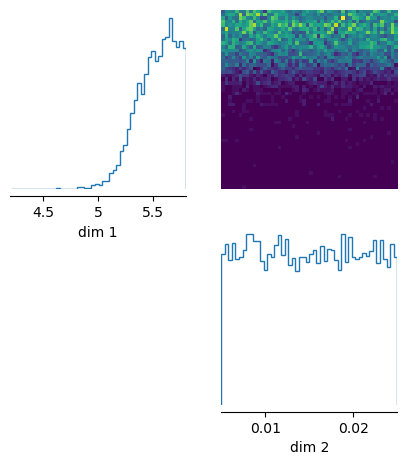

In [23]:
posterior_samples = posteriors[6].sample((10000,), x=x_o)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=[[4.2, 5.8], [0.005, 0.025]], figsize=(5, 5)
)

In [8]:
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=2000)

Running 2000 simulations.:   0%|          | 0/2000 [00:00<?, ?it/s]

Running 2000 simulations.: 100%|██████████| 2000/2000 [00:04<00:00, 440.53it/s]


In [9]:
density_estimator = inference.append_simulations(theta, x).train()

 Neural network successfully converged after 192 epochs.

In [10]:
posterior = inference.build_posterior(density_estimator)

Once we have obtained the posterior, we can `.sample()`, `.log_prob()`, or `.pairplot()` in the same way as for the simple interface.

In [11]:
# Example usage:
c = 5.3
noise_std = 0.015  # Standard deviation of the additive noise

x_o = generate_ar1_time_series([c, noise_std])
plt.plot(x_o, label='Time Series Data', color='blue', marker='o', linestyle='-')

Drawing 10000 posterior samples: 10492it [00:00, 836421.37it/s]           


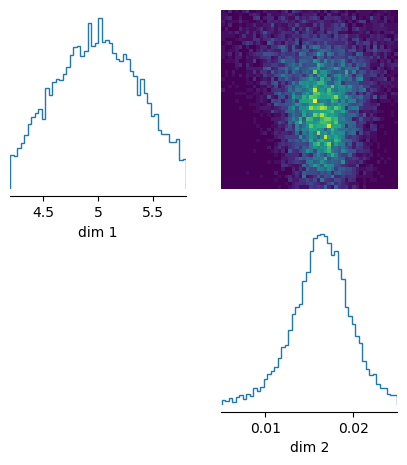

In [13]:
posterior_samples = posterior.sample((10000,), x=x_o)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=[[4.2, 5.8], [0.005, 0.025]], figsize=(5, 5)
)

We can always print the posterior to know how it was trained:

In [19]:
proposal = posterior.set_default_x(x_o)

In [20]:
theta, x = simulate_for_sbi(simulator, proposal, num_simulations=1000)

Drawing 1000 posterior samples: 1091it [00:00, 35573.41it/s]            
Running 1000 simulations.: 100%|██████████| 1000/1000 [00:02<00:00, 439.64it/s]


In [21]:
density_estimator = inference.append_simulations(
        theta, x, proposal=proposal).train()

Using SNPE-C with atomic loss
 Neural network successfully converged after 51 epochs.

In [22]:
posterior = inference.build_posterior(density_estimator)

Drawing 10000 posterior samples: 10011it [00:00, 20366.02it/s]                          


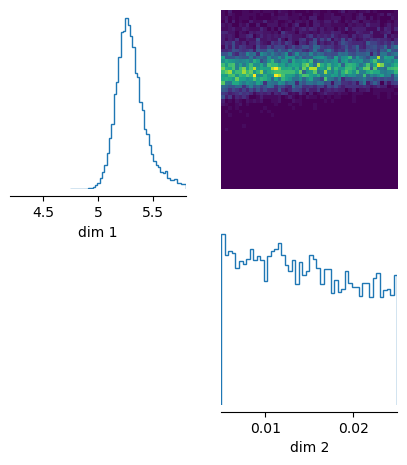

In [23]:
posterior_samples = posterior.sample((10000,), x=x_o)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=[[4.2, 5.8], [0.005, 0.025]], figsize=(5, 5)
)

Drawing 10000 posterior samples: 10113it [00:00, 47934.82it/s]                          


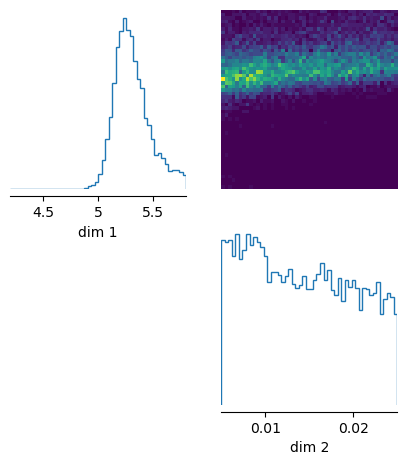

In [18]:
posterior_samples = posterior.sample((10000,), x=x_o)

# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=[[4.2, 5.8], [0.005, 0.025]], figsize=(5, 5)
)

In [51]:
AR1PostSampleArray = AR1PostSample.numpy()
np.savetxt("test.txt", AR1PostSampleArray, delimiter=',')